In [7]:
import os
CODE_DIR = '/home/joshua/Projects/diffae'
os.chdir(f'{CODE_DIR}')

In [8]:
from torchvision.utils import save_image

In [9]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

import sys
sys.path.append('/home/joshua/Projects/diffae/disentanglement/')

from Configs import Global_Config
from Configs.training_config import config, GENERATOR_IMAGE_SIZE
from Training.trainer import Trainer
from torch.utils.data import DataLoader, random_split
from Models.Encoders.Landmark_Encoder import Landmark_Encoder
from Models.Encoders.ID_Encoder import ID_Encoder
from Models.Encoders.Inception import Inception
from Models.LatentMapper import LatentMapper
from Utils.data_utils import get_w_image, Image_W_Dataset, cycle_images_to_create_diff_order
import time
import torch
import torch.utils.data
from tqdm import tqdm
from Losses import id_loss

device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

BASE_PATH = '/home/joshua/Projects/diffae/disentanglement/'
MOBILE_FACE_NET_WEIGHTS_PATH = BASE_PATH + 'CNN-project-weights/mobilefacenet_model_best.pth.tar'
GENERATOR_WEIGHTS_PATH = BASE_PATH + 'CNN-project-weights/550000.pt'
E_ID_LOSS_PATH = BASE_PATH + 'CNN-project-weights/model_ir_se50.pth'
IMAGE_DATA_DIR = BASE_PATH + 'Dataset/small_image/'
W_DATA_DIR = BASE_PATH + 'Dataset/small_w/'
MODELS_DIR = BASE_PATH + 'Models/'

id_encoder = id_loss.IDLoss(E_ID_LOSS_PATH)
# attr_encoder = torch.load(MODELS_DIR + 'attr_encoder_HPMNYYOTTIXN_1616315604.9508004_0.pt')
attr_encoder = torch.load('/home/joshua/Projects/diffae/checkpoints/attr/attr_ffhq01000_full_attr.pt')
attr_encoder = Inception(attr_encoder)
# discriminator = Discriminator()
mlp = LatentMapper()
# landmark_encoder = Landmark_Encoder.Encoder_Landmarks(MOBILE_FACE_NET_WEIGHTS_PATH)
mlp = torch.load('/home/joshua/Projects/diffae/checkpoints/MLP/mlp_ffhq01000_full_attr.pt')
# mlp = torch.load(MODELS_DIR + 'maper_HPMNYYOTTIXN_1616315604.542634_0.pt')

id_encoder = id_encoder.to(Global_Config.device)
attr_encoder = attr_encoder.to(Global_Config.device)
# discriminator = discriminator.to(Global_Config.device)
mlp = mlp.to(Global_Config.device)

id_encoder = id_encoder.eval()
attr_encoder = attr_encoder.eval()

mlp = mlp.eval()


Global seed set to 0


Model params: 160.69 M
Loading ResNet ArcFace


In [13]:
w_image_dataset = Image_W_Dataset(W_DATA_DIR, IMAGE_DATA_DIR)

In [14]:
w_image_dataset

In [15]:
data_loader = DataLoader(dataset=w_image_dataset, batch_size=1, shuffle=False)

In [16]:
data = next(iter(data_loader))

In [17]:
print(len(data))

2


In [19]:
ws, images = data

In [21]:
id_images = images * 2 - 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


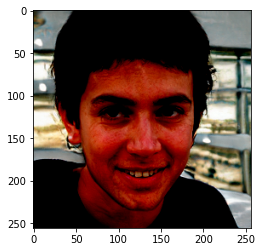

In [22]:
plt.imshow(id_images[0].permute(1, 2, 0).cpu())

In [23]:
test_id_images = images.to(Global_Config.device)
test_attr_images_cycled = cycle_images_to_create_diff_order(test_id_images)

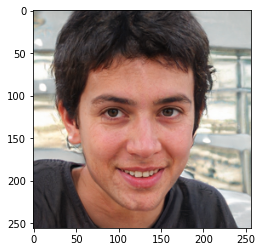

In [25]:
plt.imshow(test_attr_images_cycled[0].permute(1, 2, 0).cpu())

In [10]:
image_data = ImageDataset('00000', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
print(len(image_data))

996


In [13]:
for idx, data in enumerate(image_data):
    if idx == 2:
        break
    batch = data['img'][None]
    id_images = batch.cuda()
    attr_batch = batch*0.5+0.5
    attr_images = attr_batch.cuda()

    with torch.no_grad():
        id_vec = id_encoder.extract_feats(id_images)
        attr_vec = torch.squeeze(attr_encoder(attr_images))[None]
        encoded_vec = torch.cat((id_vec,attr_vec), dim=1)
        semantic_vec_true = model.encode(id_images)
        semantic_vec = mlp(encoded_vec)
        xT_true = model.encode_stochastic(id_images, semantic_vec_true, T=100)
        xT = model.encode_stochastic(id_images, semantic_vec, T=100)

In [6]:
with torch.no_grad():
    xT_id = model.encode_stochastic(id_images, id_vec, T=100)
    img_id = model.render(xT_id, id_vec, T=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


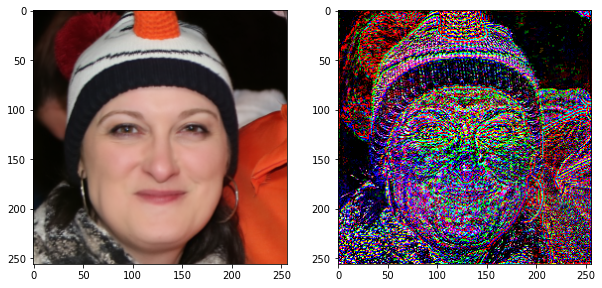

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_id[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT_id[0].permute(1, 2, 0).cpu())

In [7]:
rand_size = 0
with torch.no_grad():
    id_vec_rand = id_vec + rand_size*(random_z[0]-0.5)
    img_id_rand = model.render(xT_id, id_vec_rand, T=100)

NameError: name 'random_z' is not defined

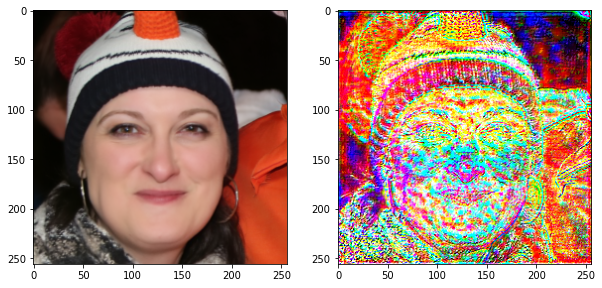

In [44]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_id[0].permute(1, 2, 0).cpu())
ax[1].imshow(img_id_rand[0].permute(1, 2, 0).cpu())

In [45]:
save_image(img_id[0].cpu(), 'img1.png')
save_image(img_id_rand[0].cpu(), 'img2.png')

In [10]:
from arcface import ArcFace
face_rec = ArcFace.ArcFace()
emb1 = face_rec.calc_emb('img1.png')
emb2 = face_rec.calc_emb('img2.png')
face_rec.get_distance_embeddings(emb1, emb2)

2023-02-15 18:15:26.782655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 18:15:26.942420: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-15 18:15:27.612102: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joshua/anaconda3/envs/proj0/lib/python3.9/site-packages/cv2/../../lib64:/usr/loca

0.99262106

In [11]:
import torch.nn as nn
L2 = nn.MSELoss()
error = L2(semantic_vec_true,semantic_vec)
print(error)

tensor(0.0073, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


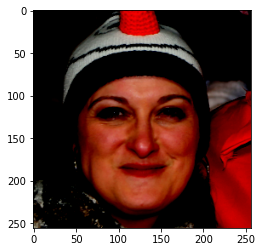

In [18]:
plt.imshow(batch[0].permute(1, 2, 0).cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


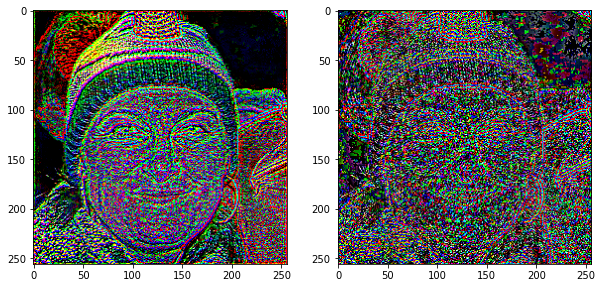

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(xT[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT_true[0].permute(1, 2, 0).cpu())

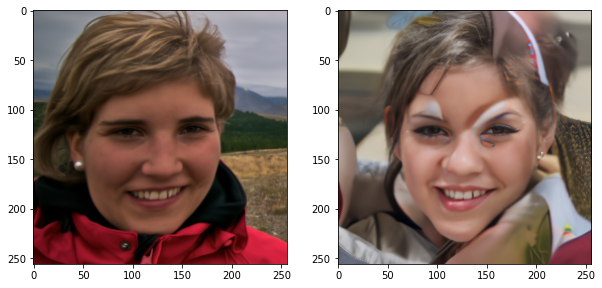

In [14]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
with torch.no_grad():
    ori = model.render(xT_true, semantic_vec_true, T=100)
    img = model.render(xT_true, semantic_vec, T=100)
# ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(img[0].permute(1, 2, 0).cpu())
# plt.savefig('imgs_manipulated/compare.png')

In [12]:
torch.min(ori[0])

tensor(0., device='cuda:0')

In [9]:
save_image(ori[0].cpu(), 'img1.png')
save_image(img[0].cpu(), 'img2.png')

## Test

### Random

In [4]:
def hy_latent(latent_np):
    hy_latent = torch.from_numpy(np.array([latent_np]))
#     hy_latent = torch.tensor(latent_np,requires_grad=True)
    hy_latent = hy_latent.to('cuda').float()
    return hy_latent

np.random.seed(50)
random_z = np.random.rand(1, 512)
random_z = hy_latent(random_z)

In [12]:
rand_size = 0.1
with torch.no_grad():
    id_vec = id_encoder.extract_feats(id_images)
    id_vec_rand = id_vec + rand_size*(random_z[0]-0.5)
    attr_vec = torch.squeeze(attr_encoder(attr_images))[None]
    encoded_vec = torch.cat((id_vec_rand,attr_vec), dim=1)
    semantic_vec = mlp(encoded_vec)
    xT = model.encode_stochastic(id_images, semantic_vec, T=100)
    rand_img = model.render(xT, semantic_vec, T=100)

In [23]:
for idx, data in enumerate(image_data):
    if idx == 1:
        break
    batch = data['img'][None]
    id_images = batch.cuda()
    attr_batch = batch*0.5+0.5
    attr_images = attr_batch.cuda()

rand_size = 2
with torch.no_grad():
    id_vec = id_encoder.extract_feats(id_images)
    id_vec_rand = id_vec + rand_size*(random_z[0]-0.5)
    xT = model.encode_stochastic(id_images, id_vec, T=100)
    img_nrand = model.render(xT, id_vec, T=100)
    rand_img = model.render(xT, id_vec_rand, T=100)

In [10]:
with torch.no_grad():
    ori = model.render(xT_true, semantic_vec_true, T=100)

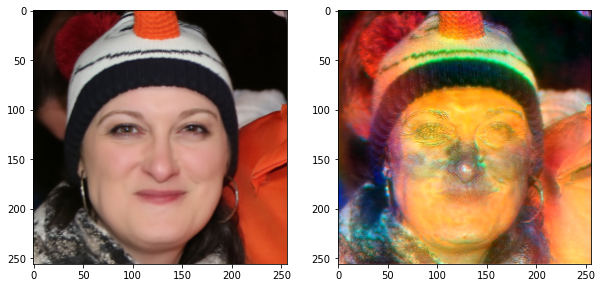

In [24]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ori = (batch + 1) / 2
ax[0].imshow(img_nrand[0].permute(1, 2, 0).cpu())
ax[1].imshow(rand_img[0].permute(1, 2, 0).cpu())

In [11]:
ori-rand_img

tensor([[[[-1.4957e-02, -1.5729e-02, -1.6574e-02,  ..., -2.6294e-02,
           -2.4500e-02, -1.9800e-02],
          [-1.6689e-02, -8.6392e-03, -1.0602e-02,  ..., -2.8338e-02,
           -1.8024e-02, -2.3928e-02],
          [-1.4815e-02, -1.1720e-02, -1.0163e-02,  ..., -2.9992e-02,
           -1.2347e-02, -2.7133e-02],
          ...,
          [-2.0320e-03,  2.9864e-03, -7.7012e-03,  ...,  1.5834e-02,
            9.1531e-03,  1.2889e-02],
          [ 2.0339e-03,  1.1021e-02, -7.4494e-04,  ...,  2.3247e-02,
            1.7112e-02,  2.0981e-02],
          [-2.0781e-03, -4.3630e-03,  4.5890e-03,  ...,  1.7731e-02,
            1.5950e-02,  2.9071e-02]],

         [[-4.4924e-03, -4.3619e-03, -5.2353e-03,  ..., -4.2594e-02,
           -4.1675e-02, -3.4539e-02],
          [-8.1948e-03, -4.4727e-03, -2.9551e-03,  ..., -4.3779e-02,
           -4.2628e-02, -3.9223e-02],
          [-6.9044e-03, -5.0556e-03, -6.2746e-04,  ..., -5.0324e-02,
           -3.8199e-02, -3.8525e-02],
          ...,
     